In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import torch 
from torch.utils import data
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
from scInferCode.utils import screen_candidate
from scInferCode.utils import add_cluster_info
from scInferCode.utils import make_infer_dataset
from scInferCode.model import InferNetwork, ClusterLoss
from scInferCode.utils import train_infer
from scInferCode.utils import scInferDataset
from scInferCode.utils import infer_protein

In [3]:
rna = sc.read_h5ad('./scInferData/BreastTask/rna.h5ad')
protein = sc.read_h5ad('./scInferData/BreastTask/protein.h5ad')

In [4]:
rna_em = sc.read_h5ad('./scInferData/BreastTask/rna_embeddings.h5ad')
protein_em = sc.read_h5ad('./scInferData/BreastTask/protein_embeddings.h5ad')

In [5]:
threshold = 0.75
min_prt_num = 3
screen_num = 20
temperature = 3

In [6]:
candidate_df, black_list = screen_candidate(rna_em, protein_em, threshold, screen_num, min_prt_num)

There are 1 rna cells cannot find candidate protein cells.


In [7]:
rna = rna[~rna.obs_names.isin(black_list)]

In [8]:
rna.obs = rna.obs.merge(candidate_df[[f'match_{screen_num}_largest']], left_index=True, right_index=True, how='left')

/home/yuzhi/project2024/scInfer/scInferCode/utils.py:226: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(rna_hv, resolution=resolution)


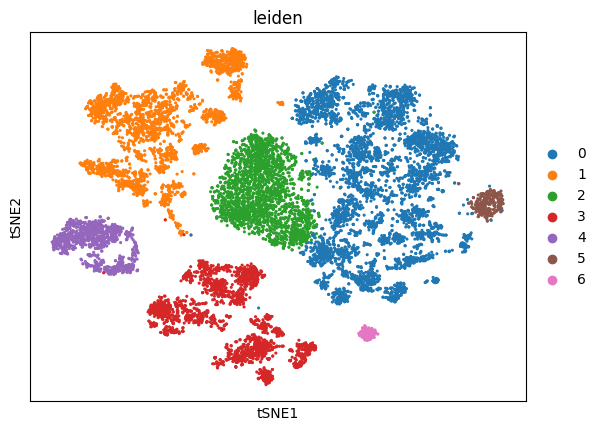

In [9]:
rna_hv = add_cluster_info(rna, resolution=0.1, cluster_by='highly_variable')

In [10]:
match_list_df, protein_df, train_dataset, test_dataset = make_infer_dataset(rna_hv, screen_num, protein, valid_ratio=0.3)

/home/yuzhi/project2024/scInfer/scInferCode/utils.py:261: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = ids.groupby(by)


In [11]:
input_size = train_dataset.get_size() 
batch_size = 2048
num_epochs = 40
lr = 0.5
patience = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InferNetwork(input_size,output_size=screen_num, t=temperature).to(device)
criterion = ClusterLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [12]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size, shuffle=False)

model: InferNetwork | lr: 0.5 | batch_size: 2048
lr: 0.450000
epoch:0| Train Loss: 0.03259632498376291 | Test Loss: 0.9199428039343178
epoch:1| Train Loss: 0.026454205344810085 | Test Loss: 0.7234882617946732
epoch:2| Train Loss: 0.02248950228335371 | Test Loss: 0.7234882617946732
epoch:3| Train Loss: 0.022305589500667772 | Test Loss: 0.6722773467602373
epoch:4| Train Loss: 0.022014851898075873 | Test Loss: 0.6438277349295954
epoch:5| Train Loss: 0.022078578299233747 | Test Loss: 0.5415333024035158
epoch:6| Train Loss: 0.022038821660074454 | Test Loss: 0.42536792857074646
epoch:7| Train Loss: 0.021961956760437055 | Test Loss: 0.36338755410197177
epoch:8| Train Loss: 0.021956993407060026 | Test Loss: 0.28681847374918856
epoch:9| Train Loss: 0.021940393659230287 | Test Loss: 0.2673563637469322
lr: 0.405000
epoch:10| Train Loss: 0.021954128911152625 | Test Loss: 0.2629804453650531
epoch:11| Train Loss: 0.02203597304054731 | Test Loss: 0.2624608680272821
epoch:12| Train Loss: 0.02194130198

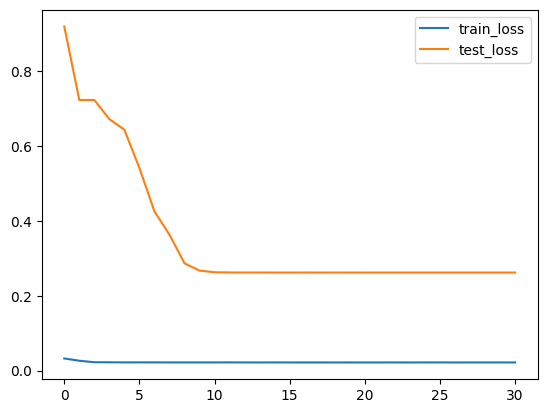

In [13]:
model = train_infer(train_loader, test_loader, model, criterion, num_epochs, patience, optimizer, batch_size, device)

In [14]:
model_path = f'./scInferData/BreastTask/BreastTaskInfer.pth'
torch.save(model.state_dict(), model_path)

In [15]:
model = InferNetwork(input_size,output_size=screen_num, t=temperature).to(device)

In [16]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [17]:
model.eval()

InferNetwork(
  (features): Sequential(
    (0): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1408, out_features=100, bias=True)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [18]:
rna_res = infer_protein(protein_df, match_list_df, device, model, protein, rna, screen_num)

In [23]:
rna.write('./scInferData/BreastTask/final_inference.h5ad')